In [1]:
! pip install pygam
from pygam import LinearGAM, LogisticGAM, s, f
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
from sklearn import linear_model

warnings.simplefilter("ignore")

In [2]:
#Read and clean
listingdf = pd.read_csv('./CLScraped.csv')

#Dropping ultra high prices and sizes
listingdf = listingdf[listingdf['price']<7500]
listingdf = listingdf[listingdf["sqft"]<10000]

#Dropping missing or very low sqft
listingdf = listingdf[listingdf['sqft']>500]

#Calculating dollars-per-square-foot
listingdf["dpsf"]=listingdf['price']/listingdf["sqft"]

#Redundant columns
listingdf.drop(columns='Unnamed: 0', inplace=True)
listingdf.drop(columns='parking', inplace=True)
listingdf.dropna(inplace=True)

#Things that caused outliers:
#this apartment just across the Charles River from MIT:
listingdf = listingdf[listingdf['lon']<-86]

#Engineering a few extra features:
listingdf["hardwood"] = listingdf.descript.str.contains("hardwood").map(int)
listingdf["carpet"] = listingdf['descript'].str.contains('carpet').map(int)
listingdf["stainless"] = listingdf.descript.str.contains("stainless").map(int)

#Theory - washer/dryer is the most cost-effective way to increase rental income
listingdf.corr()['dpsf'].sort_values(ascending=False)
listingdf.describe()

,price,beds,sqft,lat,lon,cats are OK - purrr,dogs are OK - wooof,air conditioning,furnished,w/d in unit,...,laundry in bldg,no laundry on site,no parking,street parking,off-street parking,detached garage,dpsf,hardwood,carpet,stainless
count,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,...,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000
mean,1882.195867,1.946990,1036.693621,41.898995,-87.731610,0.760108,0.548068,0.352201,0.026056,0.376460,...,0.304582,0.094340,0.066487,0.466307,0.261456,0.080863,1.877661,0.233603,0.045822,0.247080
std,769.727226,0.839596,389.787996,0.128324,0.162461,0.427209,0.497908,0.477871,0.159373,0.484715,...,0.460437,0.292432,0.249243,0.499088,0.439625,0.272746,0.621373,0.423313,0.209193,0.431508
min,625.000000,1.000000,505.000000,41.292979,-88.439898,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,1350.000000,1.000000,750.000000,41.846154,-87.766358,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.440000,0.000000,0.000000,0.000000
50%,1735.000000,2.000000,975.000000,41.906220,-87.676556,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.799544,0.000000,0.000000,0.000000
75%,2300.000000,2.000000,1200.000000,41.960873,-87.652555,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.153846,0.000000,0.000000,0.000000
max,5200.000000,5.000000,2800.000000,43.105400,-86.836753,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.801435,1.000000,1.000000,1.000000


In [3]:
#Theory - washer/dryer is the most cost-effective way to increase rental income
listingdf.corr()['dpsf'].sort_values(ascending=False)

dpsf                   1.000000
price                  0.553906
w/d in unit            0.358435
air conditioning       0.256151
lat                    0.223903
dogs are OK - wooof    0.202458
cats are OK - purrr    0.125219
stainless              0.109931
furnished              0.048016
hardwood               0.018486
lon                   -0.022421
detached garage       -0.029638
laundry on site       -0.085805
carpet                -0.086937
off-street parking    -0.087408
no parking            -0.089571
street parking        -0.093387
laundry in bldg       -0.115613
beds                  -0.200902
no laundry on site    -0.234182
sqft                  -0.265978
Name: dpsf, dtype: float64

In [4]:
listingdf[listingdf['no laundry on site']==1].describe()

,price,beds,sqft,lat,lon,cats are OK - purrr,dogs are OK - wooof,air conditioning,furnished,w/d in unit,...,laundry in bldg,no laundry on site,no parking,street parking,off-street parking,detached garage,dpsf,hardwood,carpet,stainless
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.0,...,105.0,105.0,105.000000,105.000000,105.000000,105.0,105.000000,105.000000,105.000000,105.000000
mean,1204.123810,1.914286,871.647619,41.806835,-87.682139,0.676190,0.457143,0.104762,0.047619,0.0,...,0.0,1.0,0.247619,0.485714,0.266667,0.0,1.427004,0.123810,0.038095,0.085714
std,344.640858,0.798006,283.111998,0.120420,0.127180,0.470173,0.500549,0.307715,0.213980,0.0,...,0.0,0.0,0.433699,0.502193,0.444338,0.0,0.307223,0.330944,0.192344,0.281284
min,800.000000,1.000000,530.000000,41.424928,-88.436787,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.000000
25%,945.000000,1.000000,667.000000,41.750618,-87.727958,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,1.0,0.000000,0.000000,0.000000,0.0,1.214286,0.000000,0.000000,0.000000
50%,1120.000000,2.000000,800.000000,41.808109,-87.663450,1.000000,0.000000,0.000000,0.000000,0.0,...,0.0,1.0,0.000000,0.000000,0.000000,0.0,1.427911,0.000000,0.000000,0.000000
75%,1400.000000,2.000000,1000.000000,41.880432,-87.622188,1.000000,1.000000,0.000000,0.000000,0.0,...,0.0,1.0,0.000000,1.000000,1.000000,0.0,1.595000,0.000000,0.000000,0.000000
max,2720.000000,4.000000,2100.000000,42.313985,-87.065600,1.000000,1.000000,1.000000,1.000000,0.0,...,0.0,1.0,1.000000,1.000000,1.000000,0.0,2.461538,1.000000,1.000000,1.000000


In [5]:
listingdf[listingdf['w/d in unit']==1].describe()

,price,beds,sqft,lat,lon,cats are OK - purrr,dogs are OK - wooof,air conditioning,furnished,w/d in unit,...,laundry in bldg,no laundry on site,no parking,street parking,off-street parking,detached garage,dpsf,hardwood,carpet,stainless
count,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.0,...,419.0,419.0,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000,419.000000
mean,2366.470167,2.081146,1149.754177,41.904170,-87.758514,0.797136,0.682578,0.510740,0.028640,1.0,...,0.0,0.0,0.042959,0.250597,0.365155,0.114558,2.164171,0.264916,0.047733,0.343675
std,801.504262,0.772186,406.355666,0.085593,0.163721,0.402613,0.466030,0.500482,0.166991,0.0,...,0.0,0.0,0.203008,0.433875,0.482049,0.318869,0.709512,0.441816,0.213455,0.475502
min,820.000000,1.000000,505.000000,41.568807,-88.355943,0.000000,0.000000,0.000000,0.000000,1.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.763158,0.000000,0.000000,0.000000
25%,1764.000000,2.000000,885.500000,41.846154,-87.803515,1.000000,0.000000,0.000000,0.000000,1.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.688259,0.000000,0.000000,0.000000
50%,2250.000000,2.000000,1042.000000,41.899132,-87.677756,1.000000,1.000000,1.000000,0.000000,1.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.965726,0.000000,0.000000,0.000000
75%,2800.000000,3.000000,1300.000000,41.945966,-87.660055,1.000000,1.000000,1.000000,0.000000,1.0,...,0.0,0.0,0.000000,0.500000,1.000000,0.000000,2.641561,1.000000,0.000000,1.000000
max,5200.000000,5.000000,2800.000000,42.340846,-87.224407,1.000000,1.000000,1.000000,1.000000,1.0,...,0.0,0.0,1.000000,1.000000,1.000000,1.000000,4.801435,1.000000,1.000000,1.000000


In [77]:
y = listingdf['price']
x = listingdf[['beds', 'sqft', 'baths', 'lat',
               'lon', 'cats are OK - purrr','dogs are OK - wooof',
               'air conditioning', 'furnished', 'w/d in unit','laundry on site',
               'laundry in bldg', 'no laundry on site','no parking',
               'street parking', 'off-street parking', 'detached garage',
               'hardwood', 'stainless', 'carpet']].dropna().copy()

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

<Figure size 640x480 with 0 Axes>

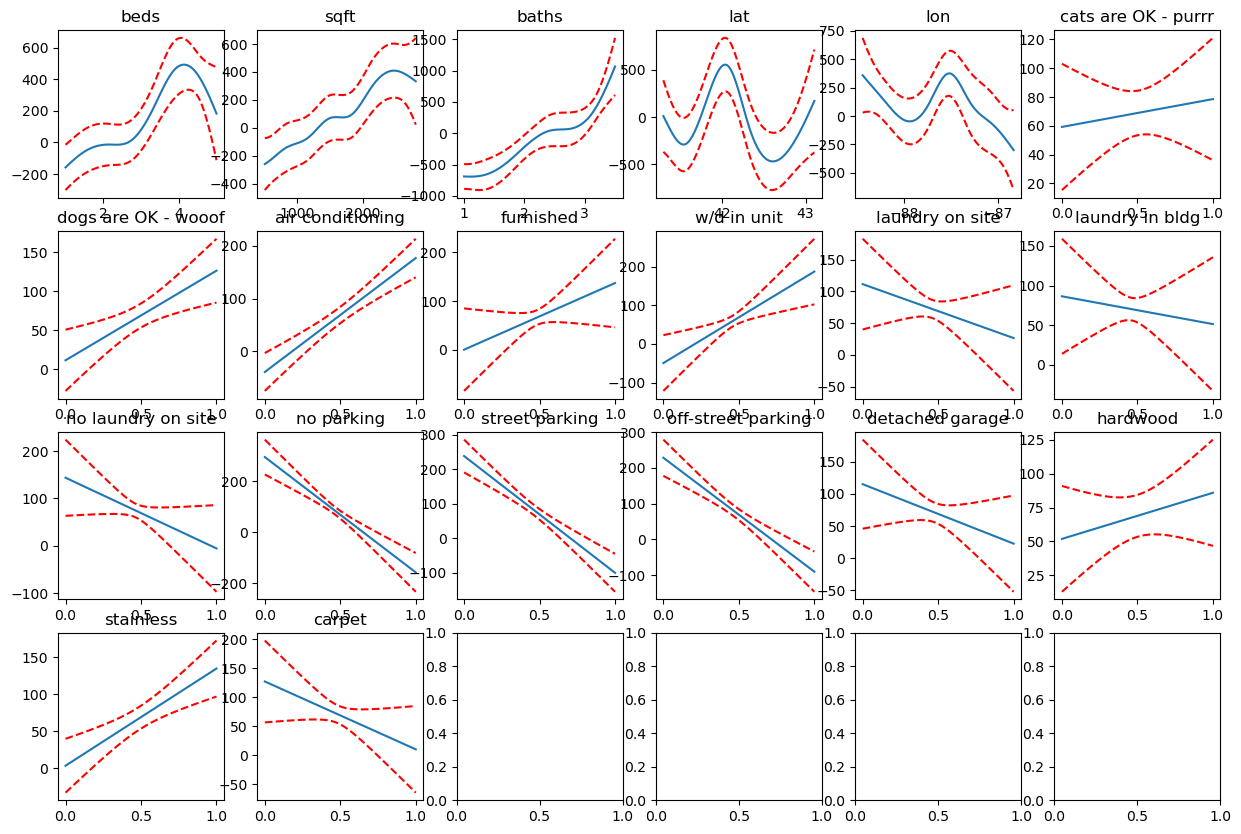

<Figure size 640x480 with 0 Axes>

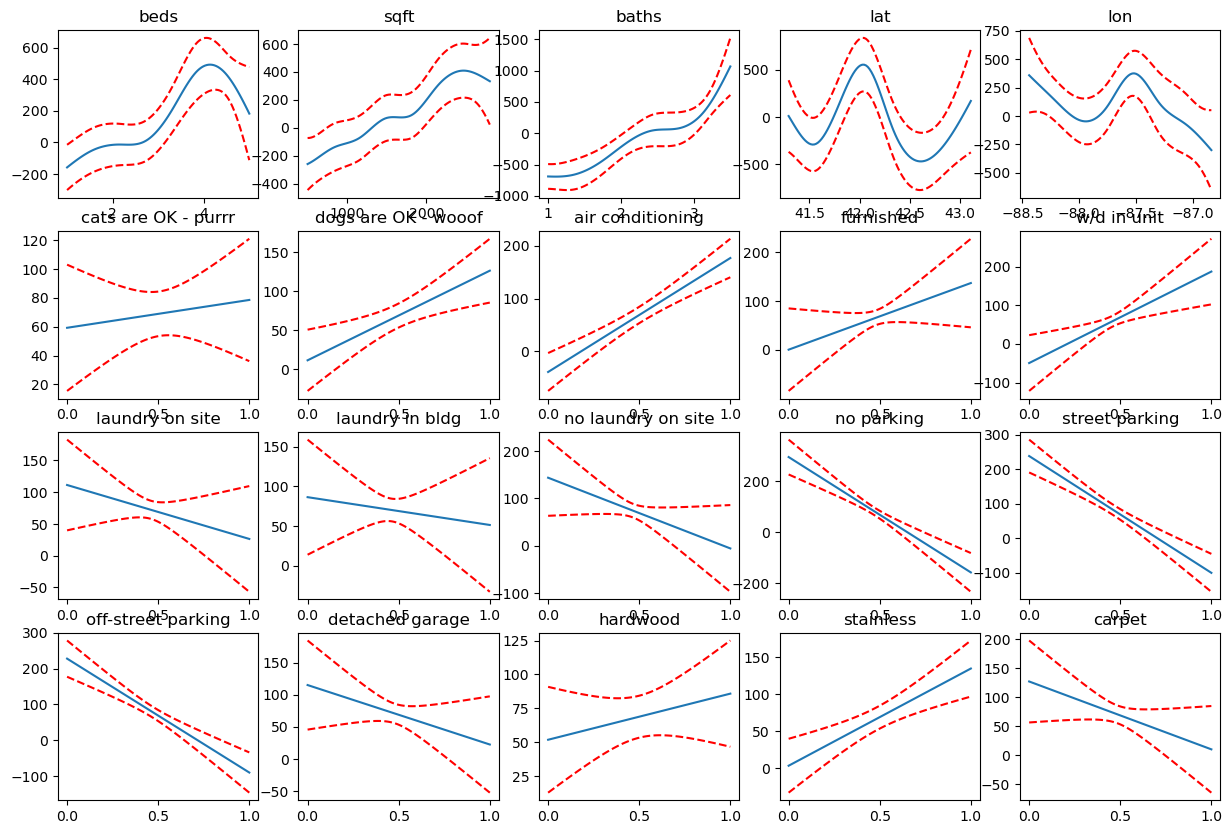

In [93]:
import numpy as np
lams = np.random.rand(100, 11)
lams = lams * 11 - 3
lams = np.exp(lams)
#print(lams.shape)
gam = LinearGAM(n_splines=10)
gam.fit(xtrain, ytrain)

titles = x.columns
plt.figure()
fig, axs = plt.subplots(4,(len(x.columns)//4),figsize=(15, 10))

acc=0
for i, a in enumerate(axs):
    for k, ax in enumerate(a):
        XX = gam.generate_X_grid(term=acc)
        ax.plot(XX[:, acc], gam.partial_dependence(term=acc, X=XX))
        ax.plot(XX[:, acc], gam.partial_dependence(term=acc, X=XX, width=.95)[1], c='r', ls='--')
        ax.set_title(titles[acc])
        acc+=1
    
plt.show()

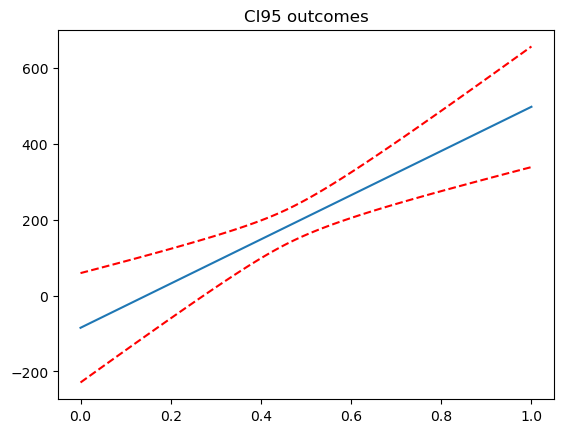

In [151]:
conf_outcomes = [0, 0]
mean_outcomes=[]
for n in [7,9,18]:
    term = gam.terms[n]
    XX = gam.generate_X_grid(term=n)
    pdep, confi = gam.partial_dependence(term=n, X=XX, width=0.95)
    mean_outcomes.append(pdep)
    conf_outcomes+=confi

plt.figure()
plt.plot(XX[:, term.feature], np.array(mean_outcomes).sum(axis=0))
plt.plot(XX[:, term.feature], conf_outcomes, c='r', ls='--')
plt.title("CI95 outcomes")
plt.show()

In [173]:
ci95_high = conf_outcomes[-1][1]-conf_outcomes[0][0]
ci95_low = conf_outcomes[-1][0]-conf_outcomes[0][1]
print("CI95 ranges from $"+str(round(ci95_low))+" to $"+str(round(ci95_high)))

CI95 ranges from $280 to $887


In [178]:
std = (ci95_high-ci95_low)/1.96

In [174]:
mean_outcome = np.array(mean_outcomes).sum(axis=0)[-1]
mean_outcome

498.36254434678324